*Working as a single .ipynb in Colab*



---



**Workflow ------->>> with customer review,**
- understanding why reviews actually matter, and how can we use then effectively
- preprocessing-> visualization -> sentiment analysis -> aspect level sentiment analyis
- filtering out important reviews, like working on them/solving those problem gives us highest ROI.
- developing a monitoring system capable of notifying in case of negative reviews in real time. This is help us to deal with negative electric word of mouth

# **Why Customer Reviews actually Matter? How can a company grow using these reviews effectively?**

In today's competitive business environment, customer feedback plays a crucial role in shaping the quality of service and driving continuous improvement. Gathering, analyzing, and implementing feedback isn't just about fixing problems—it's about fostering a customer-centric culture that ensures long-term success. (read more :[The Role of Customer Feedback in Service Improvement](https://www.linkedin.com/pulse/role-customer-feedback-service-improvement-netish-sharma-iwv4c/))

[Do companies take customer reviews seriously?](https://www.quora.com/Do-companies-take-customer-reviews-seriously)

[Why Online Reviews are Important for Customers & Businesses](https://terakeet.com/blog/online-reviews/)

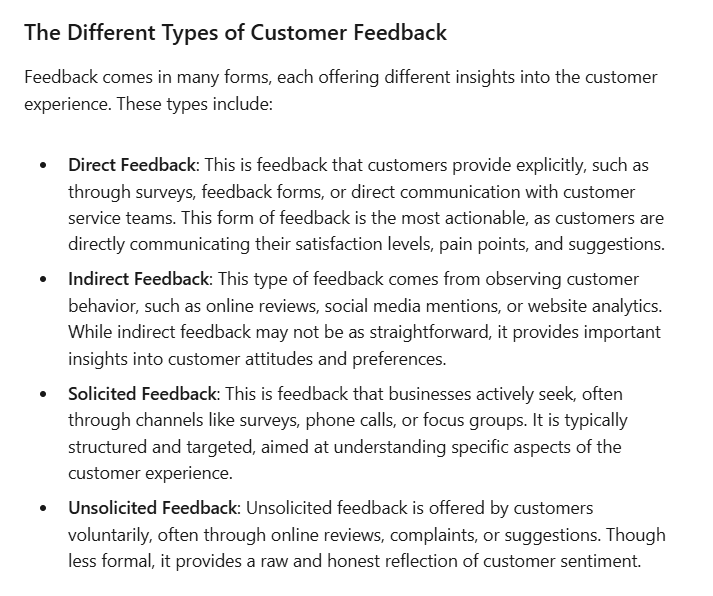

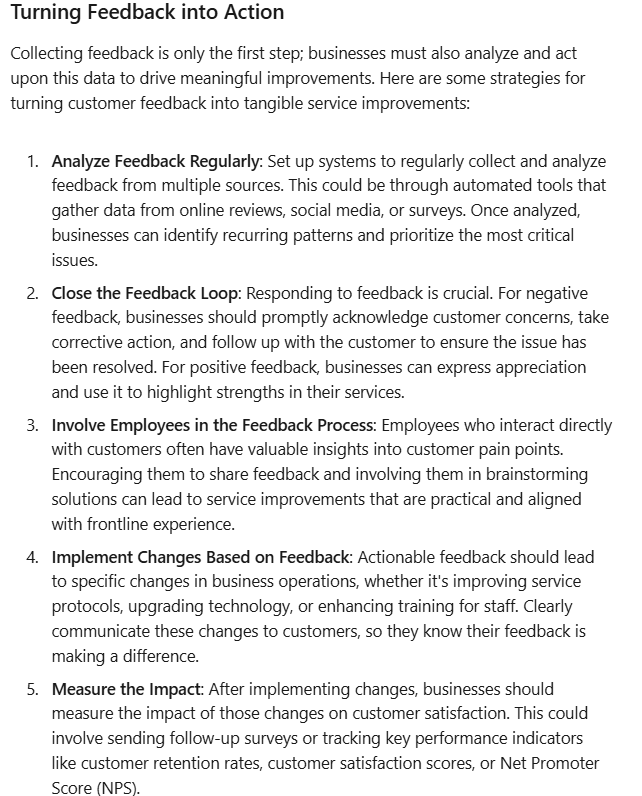

# Importing Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from tqdm import tqdm

# **Preprocessing**

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [4]:
df = pd.read_csv('data\original_dataset.csv')
df.head()

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


**Taking only the required part of dataset**

In [5]:
df = df[df['Customer Remarks'].notna()][['Customer Remarks', 'CSAT Score']]

In [6]:
df.shape

(28742, 2)

In [7]:
df.head()

,Customer Remarks,CSAT Score
7,Very good,5
8,Shopzilla app and it's all coustomer care services is very good service provided all time,5
11,Very bad,1
17,Something,3
19,All good,5


In [8]:
df = df.drop(columns=["index"], errors="ignore").reset_index(drop=True)       # to drop the orignal index and get new index


In [9]:
df[:15]

,Customer Remarks,CSAT Score
0,Very good,5
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5
2,Very bad,1
3,Something,3
4,All good,5
5,Good,5
6,Godd job,5
7,Issue not resolved pathetic service,1
8,Excellent,5
9,Very good,4


In [10]:
# Download once
nltk.download('punkt_tab')   # for tokentisation
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\91809\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91809\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Define the preprocessing function
def preprocess_text(text):
    text = str(text).lower()                        # lowercase and ensure string
    text = re.sub(r'[\[\](){}]', ' ', text)         # remove brackets
    text = re.sub(r'[^\w\s]', ' ', text)            # remove punctuation (keep words and whitespace)
    text = re.sub(r'\s+', ' ', text).strip()        # remove extra whitespace

    tokens = word_tokenize(text)                    # tokenize
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return ' '.join(tokens)

In [12]:
df['cleaned_remarks'] = df['Customer Remarks'].apply(preprocess_text)
df[:100]

,Customer Remarks,CSAT Score,cleaned_remarks
0,Very good,5,good
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5,shopzilla app coustomer care services good service provided time
2,Very bad,1,bad
3,Something,3,something
4,All good,5,good
5,Good,5,good
6,Godd job,5,godd job
7,Issue not resolved pathetic service,1,issue resolved pathetic service
8,Excellent,5,excellent
9,Very good,4,good


Stopwords include "not" due to which meaning gets completely changes, sometimes; we might need other library or handle this.

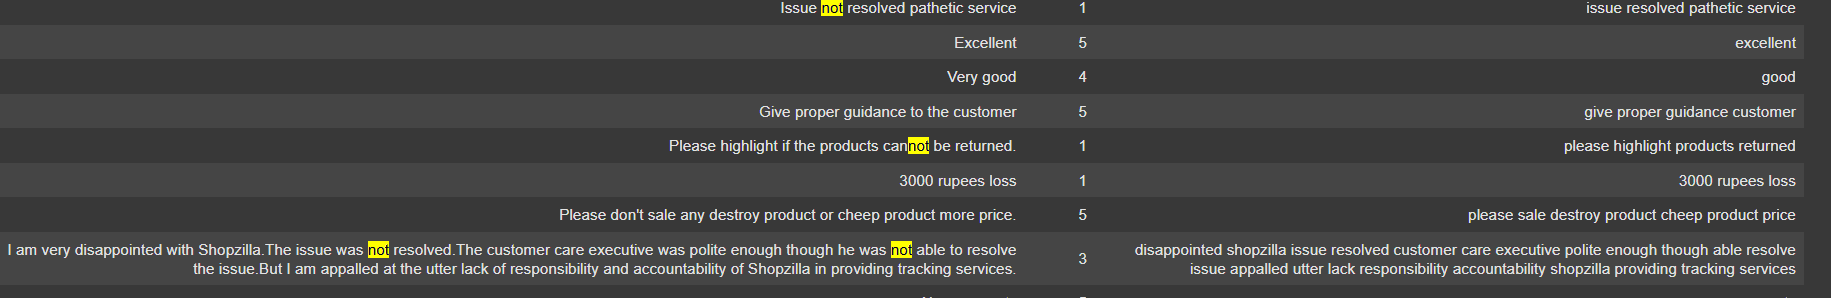

In [13]:
# Remove negation-related words from stopword list
negation_words = {'not', 'no', 'nor', 'never', 'none', "don't", "wasn't", "isn't", "shouldn't", "wouldn't"}
stop_words = stop_words.difference(negation_words)

In [14]:
# Define the preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # lowercase and ensure string
    text = re.sub(r'[\[\](){}]', ' ', text)         # remove brackets
    text = re.sub(r'[^\w\s]', ' ', text)            # remove punctuation (keep words and whitespace)
    text = re.sub(r'\s+', ' ', text).strip()        # remove extra whitespace

    tokens = word_tokenize(text)                    # tokenize
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return ' '.join(tokens)

df['cleaned_remarks'] = df['Customer Remarks'].apply(preprocess_text)
df[:100]

,Customer Remarks,CSAT Score,cleaned_remarks
0,Very good,5,good
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5,shopzilla app coustomer care services good service provided time
2,Very bad,1,bad
3,Something,3,something
4,All good,5,good
5,Good,5,good
6,Godd job,5,godd job
7,Issue not resolved pathetic service,1,issue not resolved pathetic service
8,Excellent,5,excellent
9,Very good,4,good


Issue resolved after changing the stop words list in

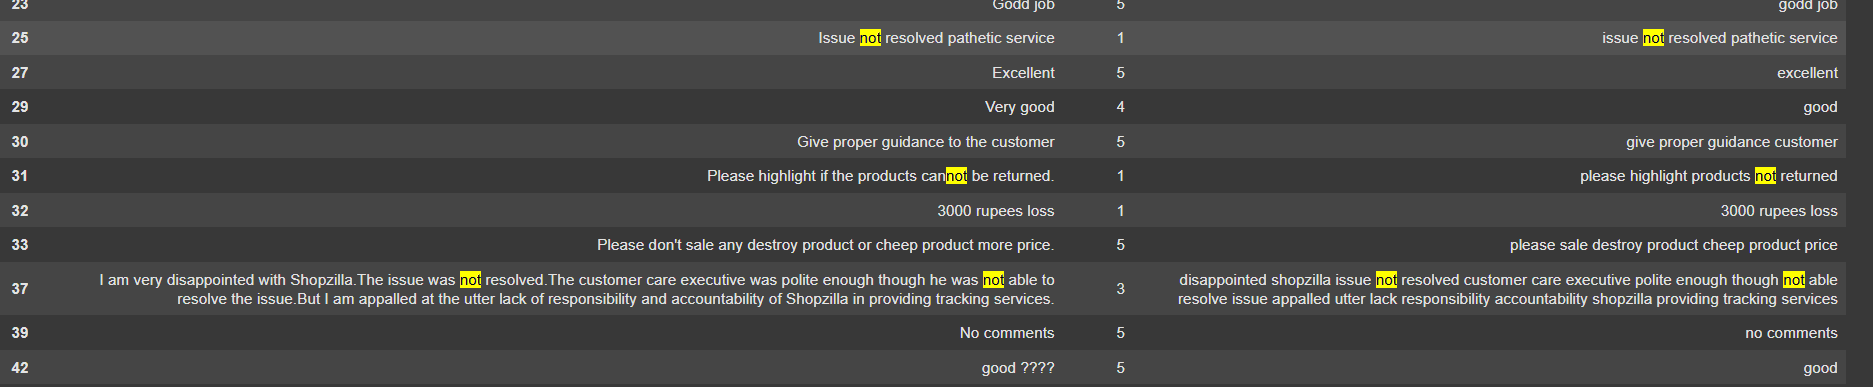

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28742 entries, 0 to 28741
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Customer Remarks  28742 non-null  object
 1   CSAT Score        28742 non-null  int64 
 2   cleaned_remarks   28742 non-null  object
dtypes: int64(1), object(2)
memory usage: 673.8+ KB


In [17]:
df = df[df['cleaned_remarks'].notna()]
df = df[df['cleaned_remarks'].str.strip() != ""]
print(f"Now the shape of df is  {df.shape}")
df.to_csv('data\cleaned_review.csv',index=False)

Now the shape of df is  (28222, 3)


# **Visualizations**

In [20]:
cleaned_reviews = 'data\cleaned_review.csv'

In [ ]:
df = pd.read_csv(cleaned_reviews)
df[:20]

,Customer Remarks,CSAT Score,cleaned_remarks
0,Very good,5,good
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5,shopzilla app coustomer care services good service provided time
2,Very bad,1,bad
3,Something,3,something
4,All good,5,good
5,Good,5,good
6,Godd job,5,godd job
7,Issue not resolved pathetic service,1,issue not resolved pathetic service
8,Excellent,5,excellent
9,Very good,4,good


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28222 entries, 0 to 28221
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Customer Remarks  28222 non-null  object
 1   CSAT Score        28222 non-null  int64 
 2   cleaned_remarks   28222 non-null  object
dtypes: int64(1), object(2)
memory usage: 661.6+ KB


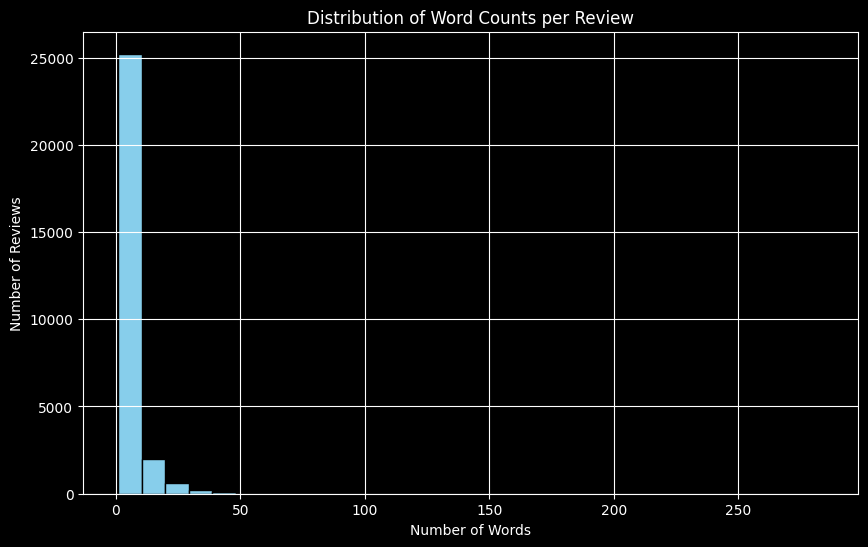

In [22]:
# Count number of words per review
df['word_count'] = df['cleaned_remarks'].fillna('').apply(lambda x: len(x.split()))

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts per Review')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

In [23]:
df.describe()

,CSAT Score,word_count
count,28222.000000,28222.000000
mean,4.071788,4.798739
std,1.561248,7.710664
min,1.000000,1.000000
25%,4.000000,1.000000
50%,5.000000,2.000000
75%,5.000000,5.000000
max,5.000000,284.000000


So the max token length is 284. This is an important paramerter to note, since distilbert only allows 512 tokens rest are truncated.

In [24]:
positive_df = df[df['CSAT Score'].isin([4,5])]
neutral_df  =  df[df['CSAT Score']==3]
negative_df = df[df['CSAT Score'].isin([1,2])]

In [25]:
# make the word cloud
def plt_wordcloud(text, title):

  text = text.fillna('').astype(str)
  all_text = ' '.join(text)

  wordcloud = WordCloud(width = 400, height= 200, background_color='black').generate(all_text)

  plt.figure(figsize=(10,6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(title)
  plt.show()

# get most occuring words
def get_top_words(text, top_n = 10):

  all_text = ' '.join(text.astype(str))

  words = all_text.split()
  words_count = Counter(words)
  top_words = words_count.most_common(top_n)

  return pd.DataFrame(top_words, columns=['Words','Frequency'])

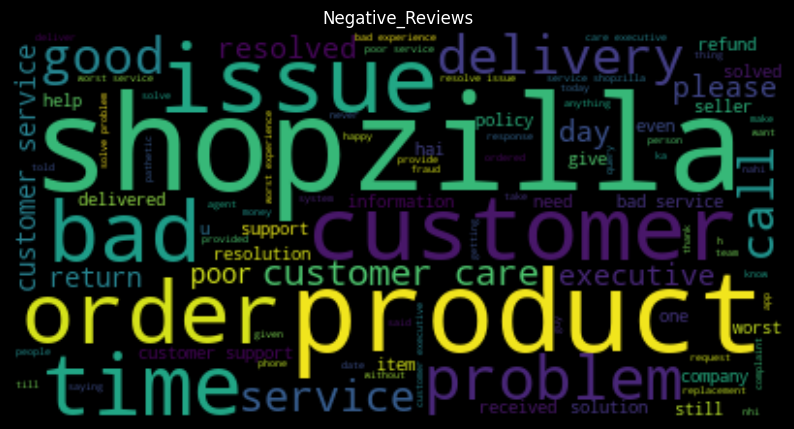

In [26]:
plt_wordcloud(negative_df['cleaned_remarks'], "Negative_Reviews")

In [27]:
get_top_words(negative_df['cleaned_remarks'], 10)

,Words,Frequency
0,not,1929
1,shopzilla,1232
2,customer,1129
3,service,961
4,product,863
5,bad,653
6,issue,617
7,no,583
8,delivery,543
9,order,510


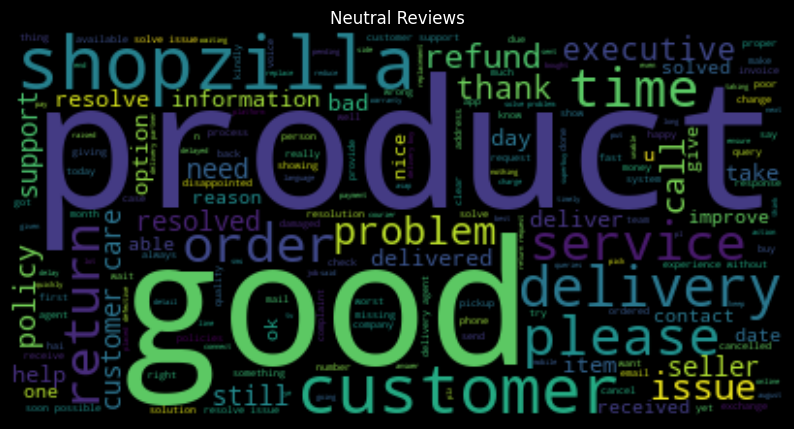

In [28]:
plt_wordcloud(neutral_df['cleaned_remarks'], "Neutral Reviews")

In [29]:
get_top_words(neutral_df['cleaned_remarks'], 10)

,Words,Frequency
0,not,179
1,good,114
2,customer,111
3,shopzilla,105
4,product,105
5,delivery,92
6,please,67
7,time,64
8,return,60
9,issue,57


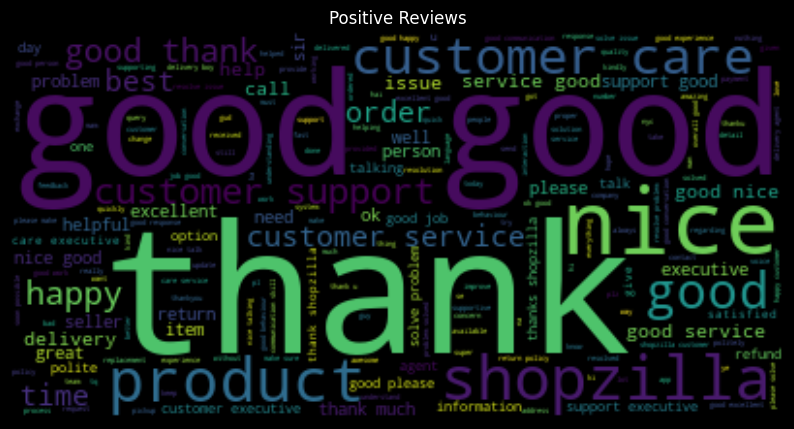

In [30]:
plt_wordcloud(positive_df['cleaned_remarks'], "Positive Reviews")

In [31]:
get_top_words(positive_df['cleaned_remarks'], 10)

,Words,Frequency
0,good,7814
1,customer,2548
2,nice,1861
3,shopzilla,1573
4,thank,1519
5,service,1482
6,thanks,1376
7,support,1229
8,not,1057
9,please,1045


# **Modeling Sentiment Analysis**

In [32]:
df = pd.read_csv(cleaned_reviews)
df.head()

,Customer Remarks,CSAT Score,cleaned_remarks
0,Very good,5,good
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5,shopzilla app coustomer care services good service provided time
2,Very bad,1,bad
3,Something,3,something
4,All good,5,good


## Rule Based Sentiment Analysis

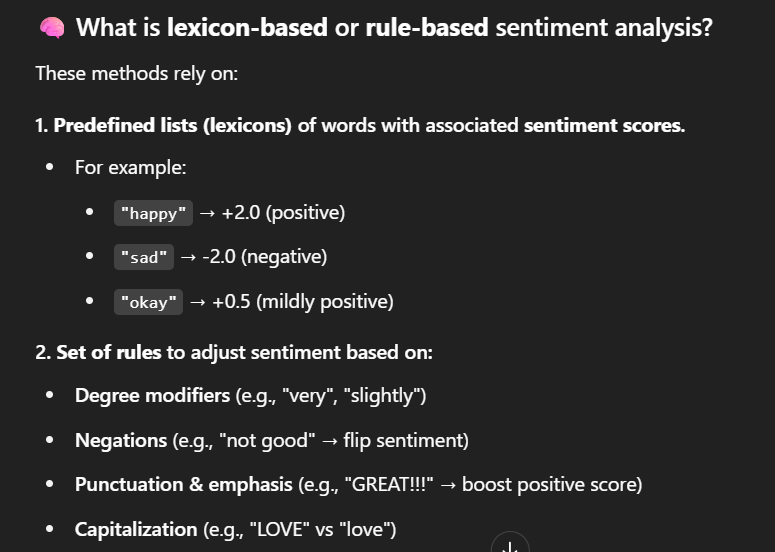

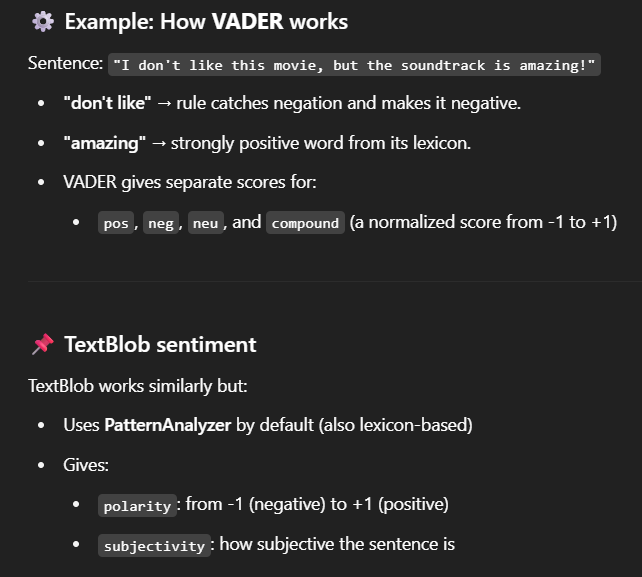

**✅ 1. VADER (Valence Aware Dictionary and sEntiment Reasoner)**

🔧 Type: Rule-based + Lexicon-based

🧠 Is it trained?

No, not in the machine learning sense.









**1. VADER**

In [33]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Define sentiment classification function
def classify_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91809\AppData\Roaming\nltk_data...


In [34]:
# Apply classification
df['Sentiment_Vader'] = df['cleaned_remarks'].apply(classify_sentiment)

# View result
print(df['Sentiment_Vader'].value_counts())

Sentiment_Vader
positive    19161
negative     4727
neutral      4334
Name: count, dtype: int64


**2. TEXT BLOB**

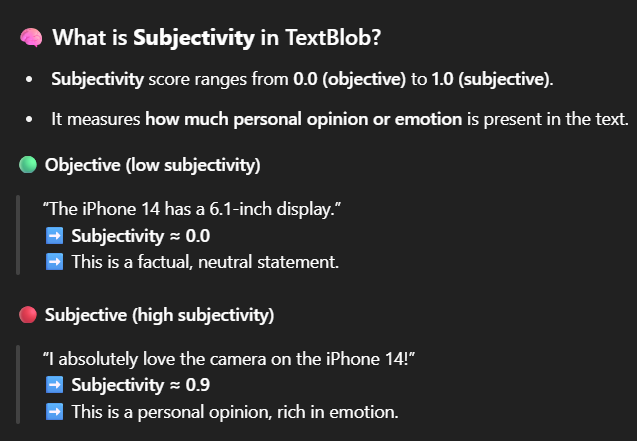

Textblob gives both polarity and subjectivity, sujectivity is helpful in emotional sentiment analysis.

In [35]:
# Define sentiment classification
def classify_sentiment_tb(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [36]:
df['Sentiment_TextBlob'] = df['cleaned_remarks'].apply(classify_sentiment_tb)

# View counts
print(df['Sentiment_TextBlob'].value_counts())

Sentiment_TextBlob
positive    16024
neutral      8682
negative     3516
Name: count, dtype: int64


Let now check, save and evaluate first 100 rows.Setting this as baseline. Also comparing these 2 methods.

In [37]:
df[:100].to_csv("data\Baseline_predictions.csv", index=False)

**Now we have to do manual eval of these 2 rule based methods. And they will serve as the baselines.**

In [38]:
df = pd.read_csv("data\Baseline_predictions.csv")
df.head()

,Customer Remarks,CSAT Score,cleaned_remarks,Sentiment_Vader,Sentiment_TextBlob
0,Very good,5,good,positive,positive
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5,shopzilla app coustomer care services good service provided time,positive,positive
2,Very bad,1,bad,negative,negative
3,Something,3,something,neutral,neutral
4,All good,5,good,positive,positive


**Let load the evaluated Baseline_predictions.csv**

In [39]:
df = pd.read_csv("data\Baseline_evals.csv")
df

,CSAT Score,Customer Remarks,cleaned_remarks,Sentiment_Vader,Sentiment_TextBlob,Human_Expert,Vader_Correct,TextBlob_Correct
0,5.0,Very good,good,positive,positive,positive,1,1
1,5.0,Shopzilla app and it's all coustomer care services is very good service provided all time,shopzilla app coustomer care services good service provided time,positive,positive,positive,1,1
2,1.0,Very bad,bad,negative,negative,negative,1,1
3,3.0,Something,something,neutral,neutral,neutral,1,1
4,5.0,All good,good,positive,positive,positive,1,1
5,5.0,Good,good,positive,positive,positive,1,1
6,5.0,Godd job,godd job,neutral,neutral,positive,0,0
7,1.0,Issue not resolved pathetic service,issue not resolved pathetic service,positive,negative,negative,0,1
8,5.0,Excellent,excellent,positive,positive,positive,1,1
9,4.0,Very good,good,positive,positive,positive,1,1


## ML/DL based Sentiment Analysis


> There are two practical ways to approach this problem:
>
> 1. **Weak Supervision using CSAT Scores**
>    We can begin by using CSAT scores (1–5) to weakly label reviews: scores 4–5 as positive, 1–2 as negative, and 3 as neutral or skip. This provides an initial labeled dataset without manual effort. However, it’s not a perfect solution, since it relies only on numeric scores and not the actual review content.
>    To improve label quality over time, we can apply **active learning**—selecting and manually labeling the most uncertain or ambiguous reviews to refine the model and reduce labeling effort overall.
>
> 2. **Start with Pretrained Sentiment Models**
>    Alternatively, we can use off-the-shelf sentiment analysis models pretrained on customer reviews (e.g. BERT variants). This gives us a strong baseline to assess performance and identify gaps.
>    Here too, **active learning** can help fine-tune or adapt the pretrained models to our domain by focusing manual labeling efforts where the model is least confident.
>
> **Combining both approaches**—starting with weak labels, leveraging pretrained models, and incrementally improving via active learning—can lead to a robust and scalable sentiment analysis pipeline with minimal manual annotation.


---


### Using Pre-Trained Models

In [40]:
df = pd.read_csv("data\Baseline_evals.csv")
print(f"Shape of the dataframe is  {df.shape}")
df.head()

Shape of the dataframe is  (101, 8)


,CSAT Score,Customer Remarks,cleaned_remarks,Sentiment_Vader,Sentiment_TextBlob,Human_Expert,Vader_Correct,TextBlob_Correct
0,5.0,Very good,good,positive,positive,positive,1,1
1,5.0,Shopzilla app and it's all coustomer care services is very good service provided all time,shopzilla app coustomer care services good service provided time,positive,positive,positive,1,1
2,1.0,Very bad,bad,negative,negative,negative,1,1
3,3.0,Something,something,neutral,neutral,neutral,1,1
4,5.0,All good,good,positive,positive,positive,1,1


In [42]:
# Load sentiment pipeline
pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


**Predicting on cleaned customer remarks**

In [43]:
# Take only the first 100 rows
batch = df.loc[:99, 'cleaned_remarks'].tolist()   # rows 0–99

# Run the pipeline
results = pipe(batch, truncation=True)

# Add results back to DataFrame
df.loc[:99, 'finetuned_cleaned_remarks'] = [res['label'].lower() for res in results]

# View label counts for the first 100
print(df.loc[:99, 'finetuned_cleaned_remarks'].value_counts())

df.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


finetuned_cleaned_remarks
positive    41
neutral     32
negative    27
Name: count, dtype: int64


,CSAT Score,Customer Remarks,cleaned_remarks,Sentiment_Vader,Sentiment_TextBlob,Human_Expert,Vader_Correct,TextBlob_Correct,finetuned_cleaned_remarks
0,5.0,Very good,good,positive,positive,positive,1,1,positive
1,5.0,Shopzilla app and it's all coustomer care services is very good service provided all time,shopzilla app coustomer care services good service provided time,positive,positive,positive,1,1,positive
2,1.0,Very bad,bad,negative,negative,negative,1,1,negative
3,3.0,Something,something,neutral,neutral,neutral,1,1,neutral
4,5.0,All good,good,positive,positive,positive,1,1,positive


**Predicting on original customer remarks**

In [44]:
# Take only the first 100 rows
batch = df.loc[:99, 'Customer Remarks'].tolist()   # rows 0–99

# Run the pipeline
results = pipe(batch, truncation=True)

# Add results back to DataFrame
df.loc[:99, 'finetuned_Customer Remarks'] = [res['label'].lower() for res in results]

# View label counts for the first 100
print(df.loc[:99, 'finetuned_Customer Remarks'].value_counts())

df.head()

finetuned_Customer Remarks
positive    43
neutral     29
negative    28
Name: count, dtype: int64


,CSAT Score,Customer Remarks,cleaned_remarks,Sentiment_Vader,Sentiment_TextBlob,Human_Expert,Vader_Correct,TextBlob_Correct,finetuned_cleaned_remarks,finetuned_Customer Remarks
0,5.0,Very good,good,positive,positive,positive,1,1,positive,positive
1,5.0,Shopzilla app and it's all coustomer care services is very good service provided all time,shopzilla app coustomer care services good service provided time,positive,positive,positive,1,1,positive,positive
2,1.0,Very bad,bad,negative,negative,negative,1,1,negative,negative
3,3.0,Something,something,neutral,neutral,neutral,1,1,neutral,neutral
4,5.0,All good,good,positive,positive,positive,1,1,positive,positive


In [45]:
df.to_csv("data\\finetuned_transformer_predictions.csv", index=False)

In [ ]:
# pd.set_option('display.max_colwidth',None)
# pd.set_option('display.max_rows',None)

**Checking the eval results**

In [46]:
df = pd.read_csv("data\\finetuned_transformer_evals.csv")
df.tail()

,CSAT Score,Customer Remarks,cleaned_remarks,Sentiment_Vader,Sentiment_TextBlob,Human_Expert,Vader_Correct,TextBlob_Correct,finetuned_cleaned_remarks,finetuned_Customer Remarks,finetuned_cleaned_remarks_correct,finetuned_Customer Remarks_correct
96,4.0,U cal display ur customers support number4 help any customers problem But no display customers care number,u cal display ur customers support number4 help customers problem no display customers care number,positive,neutral,neutral,0,1,negative,neutral,0,1
97,1.0,After delivery of the product take responsibility of the items.,delivery product take responsibility items,neutral,neutral,negative,0,0,neutral,neutral,0,0
98,5.0,Interaction was awesome but policy is very bad can't unblock my account pay later,interaction awesome policy bad unblock account pay later,positive,positive,neutral,0,0,neutral,negative,1,0
99,3.0,Reduce time,reduce time,neutral,neutral,neutral,1,1,neutral,neutral,1,1
100,NaN,NaN,NaN,NaN,NaN,NaN,65,71,NaN,NaN,80,82


**We got 82% accuracy with original customer reviews, 80% on preprocessed i.e. cleaned customer reviews. See the last row of above csv for confirmation**

# **Aspect Based Sentiment Analysis**

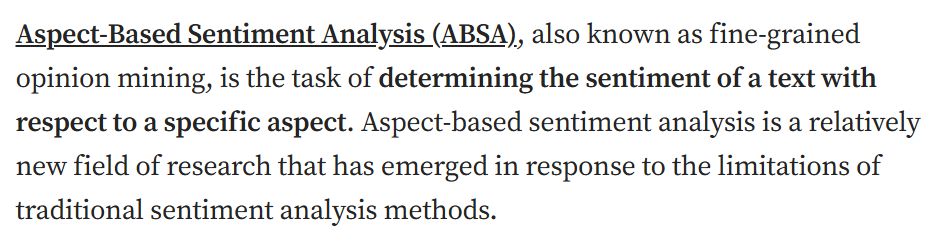

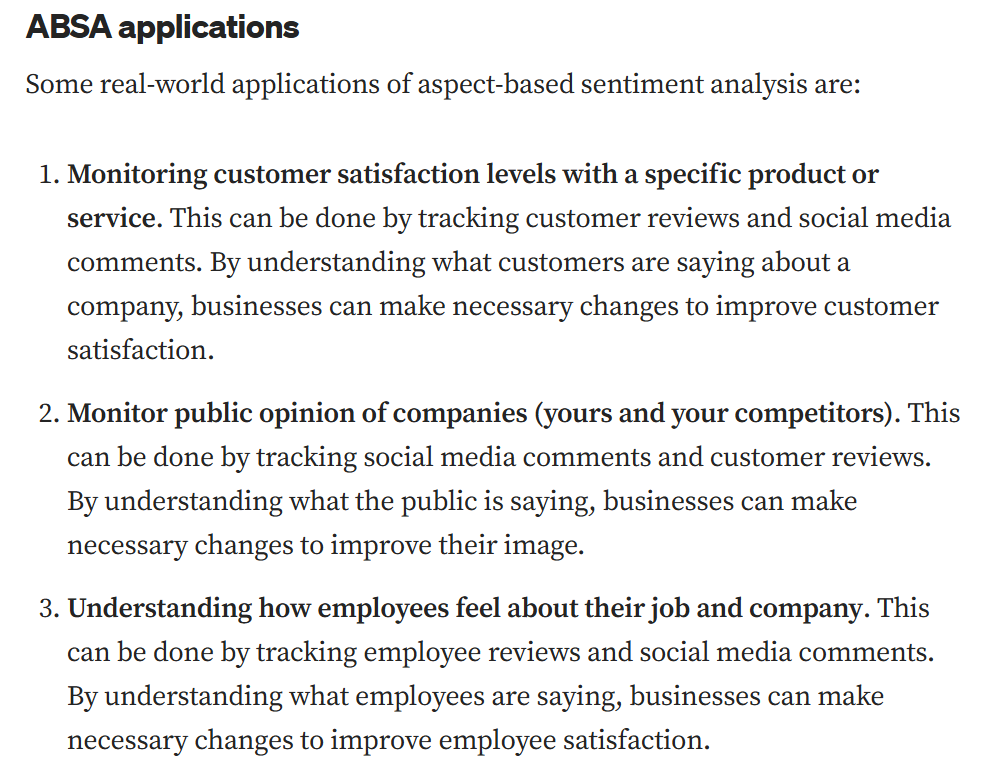

[Know more about ABSA](https://medium.com/nlplanet/quick-intro-to-aspect-based-sentiment-analysis-c8888a09eda7)

For Aspect Level Sentiment Analysis, there can be 2 approaches/possilbities, suprevised and unsupervised. We will try both since we are here to learn.

## Supervised ABSA

Shopzilla, Service, Product, Delivery

In [2]:
# Load Aspect-Based Sentiment Analysis model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

c:\Users\91809\Desktop\GITHUB\Actionable-Customer-Reviews\.venv\lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

c:\Users\91809\Desktop\GITHUB\Actionable-Customer-Reviews\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91809\.cache\huggingface\hub\models--yangheng--deberta-v3-base-absa-v1.1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not 

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

In [3]:
labels = ["negative", "neutral", "positive"]

sentence = "We had a great experience at the restaurant, food was delicious, but the service was kinda bad"

def get_aspect_sentiment(sentence, aspect):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    pred = probs.argmax(dim=1).item()   # argmax → index of best label
    return labels[pred]

# Example usage
print(f"Sentence: {sentence}\n")
print(f"Sentiment of 'food': {get_aspect_sentiment(sentence, 'food')}")
print(f"Sentiment of 'service': {get_aspect_sentiment(sentence, 'service')}")

Sentence: We had a great experience at the restaurant, food was delicious, but the service was kinda bad

Sentiment of 'food': positive
Sentiment of 'service': negative


In [4]:
labels = ["negative", "neutral", "positive"]

sentence =  "I am very disappointed with Shopzilla.The issue was not resolved.The customer care executive was polite enough though he was not able to resolve the issue.But I am appalled at the utter lack of responsibility and accountability of Shopzilla in providing tracking services."

# Example usage
print(f"Sentence: {sentence}\n")
print(f"Sentiment of 'Shopzilla': {get_aspect_sentiment(sentence, 'Shopzilla')}")
print(f"Sentiment of 'service': {get_aspect_sentiment(sentence, 'service')}")

Sentence: I am very disappointed with Shopzilla.The issue was not resolved.The customer care executive was polite enough though he was not able to resolve the issue.But I am appalled at the utter lack of responsibility and accountability of Shopzilla in providing tracking services.

Sentiment of 'Shopzilla': negative
Sentiment of 'service': negative


**Code to get the % of all sentiments; for a given sentence**

---



In [5]:
sentence = "Shopzilla customer service executive was very helpful,I appreciate her to good future ahead in your company."
print(f"Sentence: {sentence}")
print()

# ABSA of "Shopzilla"
aspect = "SHOPZILLA"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "phone"
aspect = "phone"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "food"
aspect = "food"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

Sentence: Shopzilla customer service executive was very helpful,I appreciate her to good future ahead in your company.

Sentiment of aspect 'SHOPZILLA' is:
Label negative: 0.006365002598613501
Label neutral: 0.1725306659936905
Label positive: 0.8211043477058411

Sentiment of aspect 'phone' is:
Label negative: 0.006382904015481472
Label neutral: 0.7311925292015076
Label positive: 0.2624245584011078

Sentiment of aspect 'food' is:
Label negative: 0.0075465003028512
Label neutral: 0.8497107625007629
Label positive: 0.1427427977323532



**Working on Aspect "Shopzilla"**

In [6]:
# preparing dataset
df = pd.read_csv("data\cleaned_review.csv")
shopzilla_df = df[df['cleaned_remarks'].str.contains("shopzilla", case = False, na = False)].copy()
shopzilla_df

,Customer Remarks,CSAT Score,cleaned_remarks
1,Shopzilla app and it's all coustomer care serv...,5,shopzilla app coustomer care services good ser...
14,I am very disappointed with Shopzilla.The issu...,3,disappointed shopzilla issue not resolved cust...
25,Keep it up Shopzilla,5,keep shopzilla
31,The way she talked with me is quite appropriat...,5,way talked quite appropriate nice well shopzil...
32,Please pack the products which actually custom...,4,please pack products actually customers ordere...
...,...,...,...
28186,Thanks Shopzilla,5,thanks shopzilla
28190,My issue is solved so I am very happy ?? and h...,5,issue solved happy happy rakshabandhan shopzil...
28198,"People trust Shopzilla, so please do not allow...",5,people trust shopzilla please not allow spam d...
28215,Clear all my problem thanks for Shopzilla,5,clear problem thanks shopzilla


Let's work on work first 300 rows only... that's enough to understand the concepts

In [7]:
# 2. Define sentiment labels ( model output classes )
sentiment_labels = ["negative", "neutral", "positive"]

# 3. Apply ABSA on each filtered sentence
sentiments = []
aspect = "shopzilla"

for sentence in tqdm(shopzilla_df["cleaned_remarks"][:300], desc="ABSA Progress"):
    # Tokenize with aspect format
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)

    # Convert logits to probabilities
    probs = F.softmax(outputs.logits, dim=1)
    probs = probs.detach().numpy()[0]

    # Get index of max prob → sentiment
    sentiment = sentiment_labels[probs.argmax()]
    sentiments.append(sentiment)

shopzilla_df.loc[shopzilla_df.index[:300], "absa_sentiments"] = sentiments

shopzilla_df["absa_sentiments"][:300].value_counts(normalize = True)*100

ABSA Progress: 100%|██████████| 300/300 [02:53<00:00,  1.73it/s]


absa_sentiments
negative    54.666667
positive    37.333333
neutral      8.000000
Name: proportion, dtype: float64

In [8]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None)
shopzilla_df[:50]

,Customer Remarks,CSAT Score,cleaned_remarks,absa_sentiments
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5,shopzilla app coustomer care services good service provided time,positive
14,I am very disappointed with Shopzilla.The issue was not resolved.The customer care executive was polite enough though he was not able to resolve the issue.But I am appalled at the utter lack of responsibility and accountability of Shopzilla in providing tracking services.,3,disappointed shopzilla issue not resolved customer care executive polite enough though not able resolve issue appalled utter lack responsibility accountability shopzilla providing tracking services,negative
25,Keep it up Shopzilla,5,keep shopzilla,positive
31,The way she talked with me is quite appropriate and nice as well. Shopzilla should hire these kind of executive for their customer support service. bless you dear.,5,way talked quite appropriate nice well shopzilla hire kind executive customer support service bless dear,positive
32,"Please pack the products which actually customers ordered, otherwise it is time to both you and us Shopzilla.",4,please pack products actually customers ordered otherwise time us shopzilla,negative
40,"Please don't give the chance of local shop/ company,,, they're using the name of Shopzilla & giving worst products... Sell your products like Myntra ( Myntra always send their products)",5,please give chance local shop company using name shopzilla giving worst products sell products like myntra myntra always send products,negative
47,Delete in Shopzilla account,1,delete shopzilla account,negative
64,Worst Shopzilla customer service. Shopzilla shouldn't cancel order without ack from customer and also there's no compensation for customer satisfiaction. it makes us to move out from Shopzilla.,1,worst shopzilla customer service shopzilla cancel order without ack customer also no compensation customer satisfiaction makes us move shopzilla,negative
67,"Shopzilla customer service executive was very helpful,I appreciate her to good future ahead in your company.",5,shopzilla customer service executive helpful appreciate good future ahead company,positive
72,"You have played around with this order. Without taking customers concern, how can you plan the resolution/pick-up of the products? Don't you have brain to check with the customers availability? Also, no courtesy to atleast reach customer and apologize for the mess created by Shopzilla due to systems failure. Order placed on 8 July and 19 July damaged product delivered. I'm still awaiting for the resolution and refund.",1,played around order without taking customers concern plan resolution pick products brain check customers availability also no courtesy atleast reach customer apologize mess created shopzilla due systems failure order placed 8 july 19 july damaged product delivered still awaiting resolution refund,negative


**Working on Aspect "Delivery"**

In [10]:
# preparing dataset
df = pd.read_csv("data\cleaned_review.csv")
delivery_df = df[df['cleaned_remarks'].str.contains("delivery", case = False, na = False)].copy()
delivery_df[:20]

,Customer Remarks,CSAT Score,cleaned_remarks
84,Item are too delay of delivery date,4,item delay delivery date
97,After delivery of the product take responsibility of the items.,1,delivery product take responsibility items
152,"Before delivery check all products properly.do not delivered wrong item ,like defective, broken, Because I have ordered allmost 50 order but few orders delivered properly.others defective or after using sometime they not working properly.",5,delivery check products properly not delivered wrong item like defective broken ordered allmost 50 order orders delivered properly others defective using sometime not working properly
162,"Return request was done by me but your delivery partner was not picked up the order, and my request of return was automatically cancelled by Shopzilla. Is not good thing for customer like me and other one. Please make sure that type of issues are not occur again and again.",4,return request done delivery partner not picked order request return automatically cancelled shopzilla not good thing customer like one please make sure type issues not occur
163,"I haven't received the Product, still the delivery boy has shown delivered. See now the communication gap and the status updated.",1,received product still delivery boy shown delivered see communication gap status updated
246,"Very wrost service nobody resolvoed without deliverying product delivery agent updating as product delivered it's absolutely wrong data leakaging without asking pin he has updated like this, what it shows? Till date am unable to connect with him also",1,wrost service nobody resolvoed without deliverying product delivery agent updating product delivered absolutely wrong data leakaging without asking pin updated like shows till date unable connect also
253,"Ordered on 27th with expected delivery on 29th. Put for delivery on 30th, no call, gets undeliveredDelivery agent confirms address on 31st but doesn't pick up call, marks undeliveredOn 1st, gets undelivered without a callOn the 2nd gets cancelledYour so called senior support agent is absolutely horrible and even ridiculed by pronuncing my name at the end. This rating is for him and your service with it.Not only is your service pathetic, but so are your agents.Terrible service and experience I've had",1,ordered 27th expected delivery 29th put delivery 30th no call gets undelivereddelivery agent confirms address 31st pick call marks undeliveredon 1st gets undelivered without callon 2nd gets cancelledyour called senior support agent absolutely horrible even ridiculed pronuncing name end rating service not service pathetic agents terrible service experience
265,Give option for faster delivery,1,give option faster delivery
271,Try to fix delivery hours as it is uncertain that when delivery person will arrive in whole day. Sometimes they arrive in busy hours and it becomes difficut to receive the order. So recepient should be informed about the approximate delivery time.,5,try fix delivery hours uncertain delivery person arrive whole day sometimes arrive busy hours becomes difficut receive order recepient informed approximate delivery time
292,Product cancelled without any information and got feed that u have rehected the delivery,1,product cancelled without information got feed u rehected delivery


In [11]:
from tqdm import tqdm

# Define sentiment labels
sentiment_labels = ["negative", "neutral", "positive"]
sentiments = []
aspect = "delivery"

# Wrap your loop with tqdm for progress bar
for sentence in tqdm(delivery_df["cleaned_remarks"][:300], desc="ABSA Progress"):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)

    probs = F.softmax(outputs.logits, dim=1)
    probs = probs.detach().numpy()[0]
    sentiment = sentiment_labels[probs.argmax()]
    sentiments.append(sentiment)

# Assign the sentiments back
delivery_df.loc[delivery_df.index[:300], "absa_sentiments"] = sentiments

delivery_df["absa_sentiments"][:300].value_counts(normalize = True)*100

ABSA Progress: 100%|██████████| 300/300 [02:52<00:00,  1.74it/s]


absa_sentiments
negative    66.666667
positive    26.333333
neutral      7.000000
Name: proportion, dtype: float64

In [12]:
delivery_df[:50]

,Customer Remarks,CSAT Score,cleaned_remarks,absa_sentiments
84,Item are too delay of delivery date,4,item delay delivery date,negative
97,After delivery of the product take responsibility of the items.,1,delivery product take responsibility items,negative
152,"Before delivery check all products properly.do not delivered wrong item ,like defective, broken, Because I have ordered allmost 50 order but few orders delivered properly.others defective or after using sometime they not working properly.",5,delivery check products properly not delivered wrong item like defective broken ordered allmost 50 order orders delivered properly others defective using sometime not working properly,negative
162,"Return request was done by me but your delivery partner was not picked up the order, and my request of return was automatically cancelled by Shopzilla. Is not good thing for customer like me and other one. Please make sure that type of issues are not occur again and again.",4,return request done delivery partner not picked order request return automatically cancelled shopzilla not good thing customer like one please make sure type issues not occur,negative
163,"I haven't received the Product, still the delivery boy has shown delivered. See now the communication gap and the status updated.",1,received product still delivery boy shown delivered see communication gap status updated,negative
246,"Very wrost service nobody resolvoed without deliverying product delivery agent updating as product delivered it's absolutely wrong data leakaging without asking pin he has updated like this, what it shows? Till date am unable to connect with him also",1,wrost service nobody resolvoed without deliverying product delivery agent updating product delivered absolutely wrong data leakaging without asking pin updated like shows till date unable connect also,negative
253,"Ordered on 27th with expected delivery on 29th. Put for delivery on 30th, no call, gets undeliveredDelivery agent confirms address on 31st but doesn't pick up call, marks undeliveredOn 1st, gets undelivered without a callOn the 2nd gets cancelledYour so called senior support agent is absolutely horrible and even ridiculed by pronuncing my name at the end. This rating is for him and your service with it.Not only is your service pathetic, but so are your agents.Terrible service and experience I've had",1,ordered 27th expected delivery 29th put delivery 30th no call gets undelivereddelivery agent confirms address 31st pick call marks undeliveredon 1st gets undelivered without callon 2nd gets cancelledyour called senior support agent absolutely horrible even ridiculed pronuncing name end rating service not service pathetic agents terrible service experience,negative
265,Give option for faster delivery,1,give option faster delivery,positive
271,Try to fix delivery hours as it is uncertain that when delivery person will arrive in whole day. Sometimes they arrive in busy hours and it becomes difficut to receive the order. So recepient should be informed about the approximate delivery time.,5,try fix delivery hours uncertain delivery person arrive whole day sometimes arrive busy hours becomes difficut receive order recepient informed approximate delivery time,negative
292,Product cancelled without any information and got feed that u have rehected the delivery,1,product cancelled without information got feed u rehected delivery,negative


**Working on Aspect "Service"**

In [13]:
# preparing dataset
df = pd.read_csv("data\cleaned_review.csv")
service_df = df[df['cleaned_remarks'].str.contains("service", case = False, na = False)].copy()

# Define sentiment labels
sentiment_labels = ["negative", "neutral", "positive"]
sentiments = []
aspect = "service"

# Wrap your loop with tqdm for progress bar
for sentence in tqdm(service_df["cleaned_remarks"][:300], desc="ABSA Progress"):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)

    probs = F.softmax(outputs.logits, dim=1)
    probs = probs.detach().numpy()[0]
    sentiment = sentiment_labels[probs.argmax()]
    sentiments.append(sentiment)

# Assign the sentiments back
service_df.loc[service_df.index[:300], "absa_sentiments"] = sentiments

service_df["absa_sentiments"][:300].value_counts(normalize = True)*100

ABSA Progress: 100%|██████████| 300/300 [01:35<00:00,  3.15it/s]


absa_sentiments
positive    52.666667
negative    45.000000
neutral      2.333333
Name: proportion, dtype: float64

In [14]:
service_df[:50]

,Customer Remarks,CSAT Score,cleaned_remarks,absa_sentiments
1,Shopzilla app and it's all coustomer care services is very good service provided all time,5,shopzilla app coustomer care services good service provided time,positive
7,Issue not resolved pathetic service,1,issue not resolved pathetic service,negative
14,I am very disappointed with Shopzilla.The issue was not resolved.The customer care executive was polite enough though he was not able to resolve the issue.But I am appalled at the utter lack of responsibility and accountability of Shopzilla in providing tracking services.,3,disappointed shopzilla issue not resolved customer care executive polite enough though not able resolve issue appalled utter lack responsibility accountability shopzilla providing tracking services,negative
17,customer service number plz available,5,customer service number plz available,neutral
31,The way she talked with me is quite appropriate and nice as well. Shopzilla should hire these kind of executive for their customer support service. bless you dear.,5,way talked quite appropriate nice well shopzilla hire kind executive customer support service bless dear,positive
38,I selected for English language preference but it's goes into Hindi channel. But customer service executive doesn't understand English properly,1,selected english language preference goes hindi channel customer service executive understand english properly,positive
49,Very poor service and support,1,poor service support,negative
53,No any response my orderVery bad costumer service,1,no response ordervery bad costumer service,negative
64,Worst Shopzilla customer service. Shopzilla shouldn't cancel order without ack from customer and also there's no compensation for customer satisfiaction. it makes us to move out from Shopzilla.,1,worst shopzilla customer service shopzilla cancel order without ack customer also no compensation customer satisfiaction makes us move shopzilla,negative
67,"Shopzilla customer service executive was very helpful,I appreciate her to good future ahead in your company.",5,shopzilla customer service executive helpful appreciate good future ahead company,positive


# **How to filter out important reviews, and decide solving which one gives us gives highest ROI**

# Next step: Work on real scraped data: on a latest product ____ and use this to get an intern/ job